### Sélection des données :
1. Trouver un jeu de données contenant au moins 5000 instances et 20
caractéris7ques (catégorielles, dates, numériques).
2. Le jeu de données doit être validé par l’enseignante avant son utilisation.

In [1]:
from tensorflow.keras.datasets import cifar10
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
subset_size_train = 5000
subset_size_test = 2000
indices_train = np.random.choice(x_train.shape[0], subset_size_train, replace=False)
indices_test = np.random.choice(x_test.shape[0], subset_size_test, replace=False)
x_train_subset = x_train[indices_train]
y_train_subset = y_train[indices_train]
x_test_subset = x_test[indices_test]
y_test_subset = y_test[indices_test]


In [4]:
x_train_subset.shape

(5000, 32, 32, 3)

In [5]:

x_train_flat = x_train_subset.reshape(x_train_subset.shape[0], -1) / 255.0
x_test_flat = x_test_subset.reshape(x_test_subset.shape[0], -1) / 255.0

In [6]:
print(f"Missing values in training data: {np.isnan(x_train_flat).sum()}")
print(f"Missing values in test data: {np.isnan(x_test_flat).sum()}")


Missing values in training data: 0
Missing values in test data: 0


In [7]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_flat, y_train_subset.ravel())

RandomForestClassifier(random_state=42)

In [8]:
feature_importances = rf.feature_importances_
feature_df = pd.DataFrame({
    "Feature": [f"pixel_{i}" for i in range(len(feature_importances))],
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print(feature_df.head(20))

         Feature  Importance
107    pixel_107    0.001417
5        pixel_5    0.001359
23      pixel_23    0.001076
314    pixel_314    0.000997
161    pixel_161    0.000930
14      pixel_14    0.000918
203    pixel_203    0.000861
119    pixel_119    0.000860
1013  pixel_1013    0.000853
197    pixel_197    0.000844
83      pixel_83    0.000842
104    pixel_104    0.000811
2230  pixel_2230    0.000791
173    pixel_173    0.000777
68      pixel_68    0.000776
926    pixel_926    0.000776
200    pixel_200    0.000764
164    pixel_164    0.000750
1583  pixel_1583    0.000730
53      pixel_53    0.000716


In [9]:
top_features = feature_df.index[:500]  
x_train_top = x_train_flat[:, top_features]
x_test_top = x_test_flat[:, top_features]
print(f"Reduced training shape: {x_train_top.shape}, Reduced test shape: {x_test_top.shape}")

Reduced training shape: (5000, 500), Reduced test shape: (2000, 500)


In [10]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train_top, y_train_subset.ravel())


print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best cross-validated accuracy: {grid_rf.best_score_}")


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated accuracy: 0.39920119217453026


In [11]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [None, 10, 20 , 30],
    'min_samples_split': [2, 5 , 10],
    'min_samples_leaf': [1, 2 , 4]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train_top, y_train_subset.ravel())


print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best cross-validated accuracy: {grid_rf.best_score_}")

Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best cross-validated accuracy: 0.40400167265466475


In [12]:
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(x_test_top)
cm = confusion_matrix(y_test_subset.ravel(), y_pred)



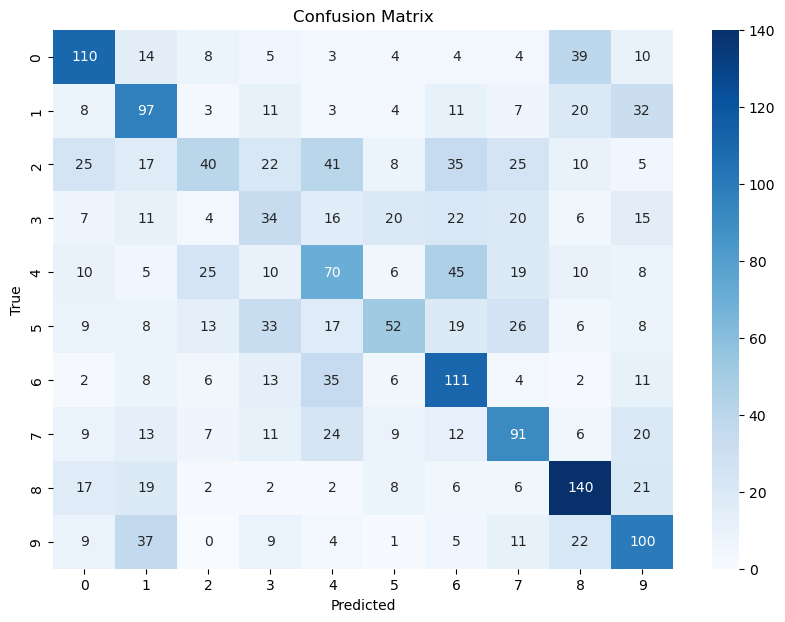

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print(classification_report(y_test_subset.ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       201
           1       0.42      0.49      0.46       196
           2       0.37      0.18      0.24       228
           3       0.23      0.22      0.22       155
           4       0.33      0.34      0.33       208
           5       0.44      0.27      0.34       191
           6       0.41      0.56      0.47       198
           7       0.43      0.45      0.44       202
           8       0.54      0.63      0.58       223
           9       0.43      0.51      0.47       198

    accuracy                           0.42      2000
   macro avg       0.41      0.42      0.41      2000
weighted avg       0.42      0.42      0.41      2000



In [15]:

y_pred_proba = best_rf.predict_proba(x_test_top)
auc_score = roc_auc_score(y_test_subset, y_pred_proba, multi_class='ovr')
print(f"Multiclass AUC (OvR): {auc_score:.4f}")

Multiclass AUC (OvR): 0.8367


In [16]:
'''
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve


mlflow.set_tracking_uri("http://127.0.0.1:5000")


with mlflow.start_run():
    
    mlflow.sklearn.log_model(
        sk_model=best_rf,
        artifact_path="model",
        registered_model_name=None  
    )

    
    mlflow.log_param("max_depth", best_rf.max_depth)
    mlflow.log_param("n_estimators", best_rf.n_estimators)

    
    accuracy = accuracy_score(y_test_subset, y_pred)
    auc_score = roc_auc_score(y_test_subset, best_rf.predict_proba(x_test_top), multi_class='ovr')
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc_score", auc_score)

    
    report = classification_report(y_test_subset, y_pred, output_dict=False)
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")

    
    cm = confusion_matrix(y_test_subset, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    
    plt.figure(figsize=(10, 7))
    for i in range(len(best_rf.classes_)):
        fpr, tpr, _ = roc_curve(y_test_subset == i, best_rf.predict_proba(x_test_top)[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Run saved in {mlflow.get_tracking_uri()}")'''




'\nimport mlflow\nimport mlflow.sklearn\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score\nfrom sklearn.metrics import roc_curve\n\n\nmlflow.set_tracking_uri("http://127.0.0.1:5000")\n\n\nwith mlflow.start_run():\n    \n    mlflow.sklearn.log_model(\n        sk_model=best_rf,\n        artifact_path="model",\n        registered_model_name=None  \n    )\n\n    \n    mlflow.log_param("max_depth", best_rf.max_depth)\n    mlflow.log_param("n_estimators", best_rf.n_estimators)\n\n    \n    accuracy = accuracy_score(y_test_subset, y_pred)\n    auc_score = roc_auc_score(y_test_subset, best_rf.predict_proba(x_test_top), multi_class=\'ovr\')\n    mlflow.log_metric("accuracy", accuracy)\n    mlflow.log_metric("auc_score", auc_score)\n\n    \n    report = classification_report(y_test_subset, y_pred, output_dict=False)\n    with open("classification_report.txt", "w") as f:\n        f.write(repo

In [17]:
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root file:///C:/Users/niman/OneDrive/Desktop/TP_Process/mlruns --host 127.0.0.1 --port 5000


2024/12/10 20:45:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run crawling-donkey-426 at: http://127.0.0.1:5000/#/experiments/0/runs/506ee20e24564b98872e543acfa207d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


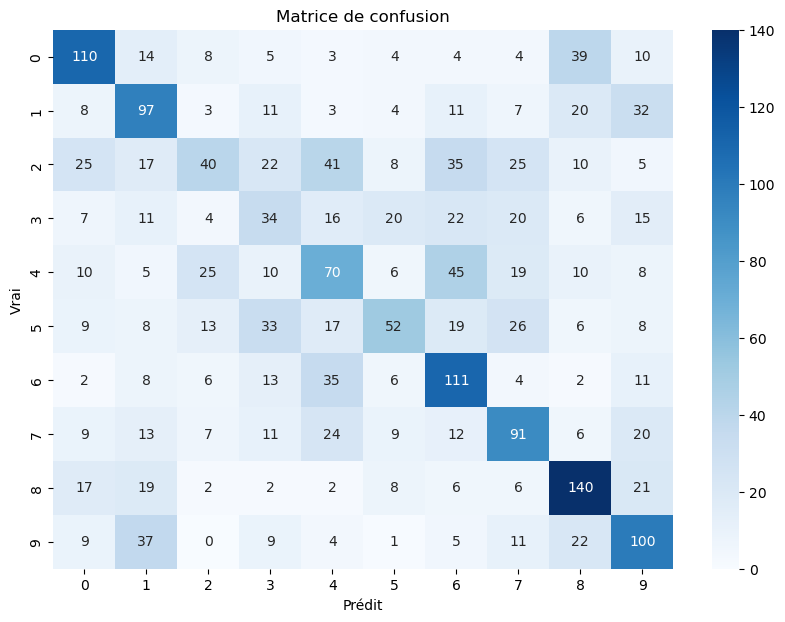

In [23]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

mlflow.set_tracking_uri("http://127.0.0.1:5000")


# Fonction d'évaluation
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test.ravel(), y_pred)
    precision = precision_score(y_test.ravel(), y_pred, average='weighted')
    recall = recall_score(y_test.ravel(), y_pred, average='weighted')
    f1 = f1_score(y_test.ravel(), y_pred, average='weighted')

    cm = confusion_matrix(y_test.ravel(), y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title("Matrice de confusion")
    plt.savefig("confusion_matrix.png")

    return accuracy, precision, recall, f1

# Lancer MLflow
with mlflow.start_run():
    # Évaluer le modèle
    accuracy, precision, recall, f1 = evaluate_model(best_rf, x_test_top, y_test_subset)

    # Journalisation des métriques
    mlflow.log_metrics({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })

    # Journaliser la matrice de confusion
    mlflow.log_artifact("confusion_matrix.png")

    # Enregistrer le modèle
    mlflow.sklearn.log_model(best_rf, "RandomForestModel")


SHAP values shape after limiting to 100 samples: [(500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500, 10), (500

ValueError: Mismatch in shape between SHAP values and input data.